# MindMetrics v2 — Emotional Well‑Being Predictor (Colab-ready)

**What's new in v2**
- Model comparison: XGBoost, RandomForest, and a simple Neural Network (MLP).
- Quick hyperparameter tuning using randomized search (lightweight).
- Automatic SHAP explainability for the best model (global + local).
- Gradio UI for questionnaire-based predictions with SHAP bar plot.
- Clear instructions to swap synthetic data for real WHO-5 / PHQ-9 / GAD-7 datasets.

> This notebook is designed to run end-to-end in Google Colab. Run the install cell first.


In [1]:
# Install required packages (run in Colab)
!pip install --quiet xgboost shap gradio pandas scikit-learn matplotlib joblib tensorflow scipy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import shap
import joblib
import gradio as gr
import warnings
warnings.filterwarnings('ignore')
print('libraries loaded')

libraries loaded


## 1) Create a synthetic clinically-inspired dataset

This synthetic dataset mimics WHO-5 style well-being percentage as the target and includes PHQ-9/GAD-7-like and lifestyle features.


In [4]:
def generate_synthetic_dataset(n=6000, random_state=42):
    rng = np.random.RandomState(random_state)
    sleep = rng.normal(7, 1.2, n).clip(3, 10)
    exercise = rng.poisson(2, n).clip(0,7)
    social = rng.normal(7, 4, n).clip(0, 40)
    screen = rng.normal(6, 2, n).clip(0, 18)
    stress = rng.randint(1,6, n)
    phq9 = (rng.poisson(1.5, n) + rng.binomial(1, 0.12, n)*rng.randint(0,9,n)).clip(0,27)
    gad7 = (rng.poisson(1.2, n) + rng.binomial(1, 0.09, n)*rng.randint(0,7,n)).clip(0,21)
    mood = rng.randint(1,6, n)
    who_raw = ( (mood*4) + (sleep-4)*1.2 + exercise*0.8 + (social/10)*0.6 - (phq9*0.35) - (gad7*0.28) - (stress*1.4) - (screen*0.15) )
    who_raw = np.interp(who_raw, (who_raw.min(), who_raw.max()), (0,25))
    who_pct = (who_raw * 4).clip(0,100)
    df = pd.DataFrame({
        'sleep_hours': np.round(sleep,2),
        'exercise_days': exercise,
        'social_hours': np.round(social,2),
        'screen_time': np.round(screen,2),
        'stress_level': stress,
        'phq9': phq9,
        'gad7': gad7,
        'mood_self': mood,
        'who_pct': np.round(who_pct,2)
    })
    return df

df = generate_synthetic_dataset(6000)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sleep_hours    6000 non-null   float64
 1   exercise_days  6000 non-null   int64  
 2   social_hours   6000 non-null   float64
 3   screen_time    6000 non-null   float64
 4   stress_level   6000 non-null   int64  
 5   phq9           6000 non-null   int64  
 6   gad7           6000 non-null   int64  
 7   mood_self      6000 non-null   int64  
 8   who_pct        6000 non-null   float64
dtypes: float64(4), int64(5)
memory usage: 422.0 KB


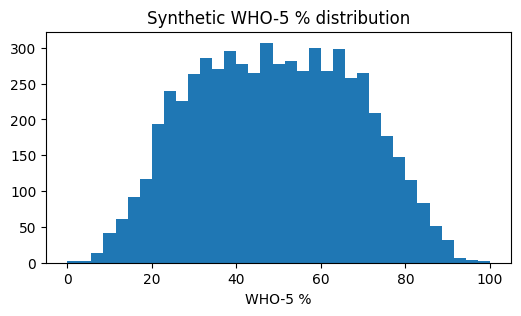

In [5]:
# Quick EDA: distribution of target
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(df['who_pct'], bins=35)
plt.title('Synthetic WHO-5 % distribution')
plt.xlabel('WHO-5 %')
plt.show()

## 2) Train/test split and baseline preprocessing


In [6]:
X = df.drop(columns=['who_pct'])
y = df['who_pct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (4800, 8) Test size: (1200, 8)


## 3) Model comparison: XGBoost, RandomForest, MLP

We train three models quickly and compare R² and MAE. For real projects, replace the quick configs with careful tuning.


In [7]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print('XGBoost R2:', round(r2_score(y_test, xgb_pred),4), 'MAE:', round(mean_absolute_error(y_test, xgb_pred),4))

# RandomForest
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print('RandomForest R2:', round(r2_score(y_test, rf_pred),4), 'MAE:', round(mean_absolute_error(y_test, rf_pred),4))

# MLP
mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=400, random_state=42)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
print('MLP R2:', round(r2_score(y_test, mlp_pred),4), 'MAE:', round(mean_absolute_error(y_test, mlp_pred),4))

XGBoost R2: 0.997 MAE: 0.7458
RandomForest R2: 0.9861 MAE: 1.6609
MLP R2: 1.0 MAE: 0.0666


In [8]:
# Identify best model (by R2)
results = {
    'xgboost': {'model': xgb_model, 'pred': xgb_pred},
    'randomforest': {'model': rf, 'pred': rf_pred},
    'mlp': {'model': mlp, 'pred': mlp_pred}
}
scores = {k: r2_score(y_test, v['pred']) for k,v in results.items()}
best_name = max(scores, key=scores.get)
best_model = results[best_name]['model']
print('Best model:', best_name, 'with R2 =', round(scores[best_name],4))

Best model: mlp with R2 = 1.0


## 4) Optional fast hyperparameter tuning (RandomizedSearch on best model)

This is lightweight; remove or expand for larger runs.


In [9]:
from scipy.stats import randint, uniform
if best_name == 'randomforest':
    param_dist = {'n_estimators': randint(100,400), 'max_depth': randint(6,20)}
    search = RandomizedSearchCV(best_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print('RandomSearch best params:', search.best_params_)
elif best_name == 'xgboost':
    param_dist = {'n_estimators': randint(100,400), 'max_depth': randint(3,10), 'learning_rate': uniform(0.01,0.2)}
    search = RandomizedSearchCV(best_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print('RandomSearch best params:', search.best_params_)
else:
    print('Skipping hyperparameter search for MLP (quick run)')

Skipping hyperparameter search for MLP (quick run)


In [10]:
# Evaluate tuned model
y_pred_best = best_model.predict(X_test)
print('Tuned model R2:', round(r2_score(y_test, y_pred_best),4), 'MAE:', round(mean_absolute_error(y_test, y_pred_best),4))
joblib.dump(best_model, 'mindmetrics_best_model.pkl')
print('Saved best model to mindmetrics_best_model.pkl')

Tuned model R2: 1.0 MAE: 0.0666
Saved best model to mindmetrics_best_model.pkl


## 5) Explainability with SHAP

We compute global importance (mean |SHAP|) and show a local explanation (waterfall) for an example user.  


In [11]:
# Create SHAP explainer depending on model type
try:
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_train)
except Exception as e:
    explainer = shap.Explainer(best_model.predict, X_train)
    shap_values = explainer(X_train)

shap_abs = np.abs(shap_values.values).mean(axis=0)
feat_imp = pd.DataFrame({'feature': X_train.columns, 'mean_abs_shap': shap_abs}).sort_values('mean_abs_shap', ascending=False)
feat_imp

ExactExplainer explainer: 4801it [04:28, 17.86it/s]                          


,feature,mean_abs_shap
7,mood_self,15.038320
4,stress_level,5.147205
0,sleep_hours,3.329292
1,exercise_days,2.635290
5,phq9,1.467507
6,gad7,0.882099
3,screen_time,0.715536
2,social_hours,0.548060


In [12]:
display(feat_imp)

,feature,mean_abs_shap
7,mood_self,15.038320
4,stress_level,5.147205
0,sleep_hours,3.329292
1,exercise_days,2.635290
5,phq9,1.467507
6,gad7,0.882099
3,screen_time,0.715536
2,social_hours,0.548060


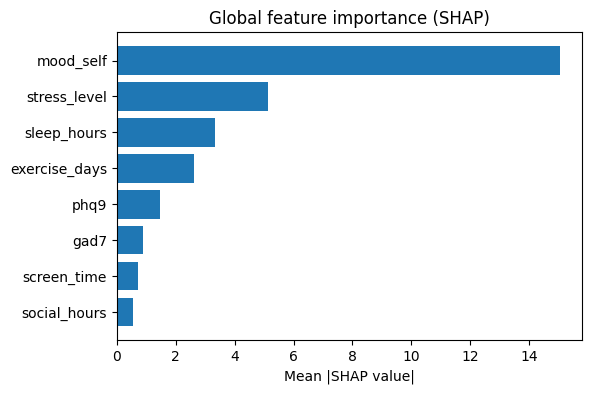

In [13]:
# Plot global importance
plt.figure(figsize=(6,4))
plt.barh(feat_imp['feature'], feat_imp['mean_abs_shap'])
plt.gca().invert_yaxis()
plt.xlabel('Mean |SHAP value|')
plt.title('Global feature importance (SHAP)')
plt.show()

Predicted WHO-%: 41.9 True: 41.73


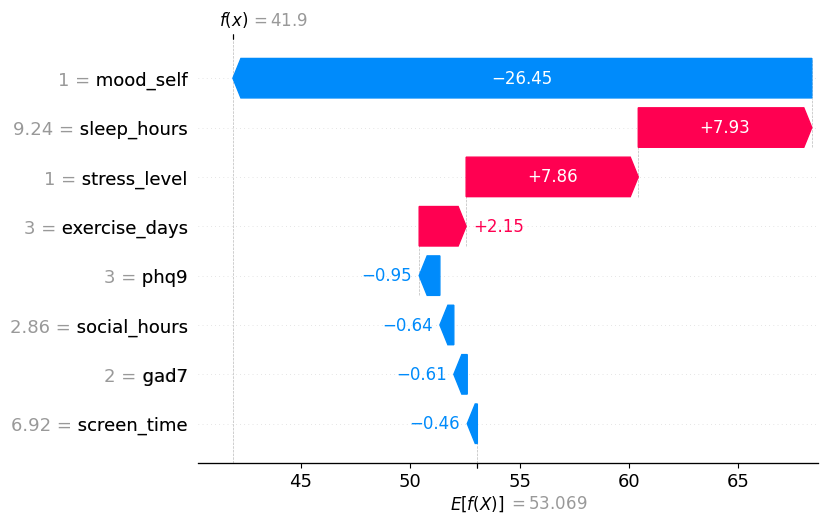

In [14]:
# Local explanation for a test instance
idx = X_test.index[7]
x_example = X_test.loc[[idx]]
pred = best_model.predict(x_example)[0]
print('Predicted WHO-%:', round(pred,2), 'True:', round(y_test.loc[idx],2))
sv = explainer(x_example)
shap.plots.waterfall(sv[0], max_display=10)

## 6) Gradio UI for questionnaire (works in Colab)

The Gradio app takes questionnaire inputs, predicts the WHO-5 percentage, assigns a category, and displays a SHAP-based local impact bar plot.


In [ ]:
# Load best model
model = joblib.load('mindmetrics_best_model.pkl')

def predict_wellbeing(sleep_hours, exercise_days, social_hours, screen_time, stress_level, phq9, gad7, mood_self):
    x = pd.DataFrame([{
        'sleep_hours': sleep_hours,
        'exercise_days': exercise_days,
        'social_hours': social_hours,
        'screen_time': screen_time,
        'stress_level': stress_level,
        'phq9': phq9,
        'gad7': gad7,
        'mood_self': mood_self
    }])
    pred = model.predict(x)[0]
    # local SHAP
    try:
        local_sv = explainer(x)[0]
        vals = pd.Series(np.abs(local_sv.values), index=x.columns).sort_values(ascending=True)
        fig, ax = plt.subplots(figsize=(6,3))
        vals.plot.barh(ax=ax)
        ax.set_title('Local |SHAP value| (feature impact)')
        ax.set_xlabel('|SHAP value|')
        plt.tight_layout()
    except Exception as e:
        fig = plt.figure()
        plt.text(0.1,0.5,'SHAP explainability failed: ' + str(e))
    if pred < 50:
        cat = 'Low'
    elif pred < 70:
        cat = 'Moderate'
    else:
        cat = 'High'
    return round(pred,2), cat, fig

inputs = [
    gr.Number(label='Sleep hours (avg per night, 0-12)', value=7),
    gr.Slider(minimum=0, maximum=7, step=1, label='Exercise days per week', value=2),
    gr.Number(label='Social hours per week', value=7),
    gr.Number(label='Screen time hours per day', value=6),
    gr.Slider(minimum=1, maximum=5, step=1, label='Stress level (1 low - 5 high)', value=3),
    gr.Slider(minimum=0, maximum=27, step=1, label='PHQ-9 total score (0-27)', value=4),
    gr.Slider(minimum=0, maximum=21, step=1, label='GAD-7 total score (0-21)', value=3),
    gr.Slider(minimum=1, maximum=5, step=1, label='Self-rated mood (1 low - 5 high)', value=3)
]
outputs = [gr.Number(label='Predicted WHO-5 % score'), gr.Label(label='Category'), gr.Plot(label='SHAP feature impact')]

demo = gr.Interface(fn=predict_wellbeing, inputs=inputs, outputs=outputs, title='MindMetrics v2 — Emotional Well-Being Predictor', description='Answer the quick questionnaire and get a WHO-5-like well-being percentage and a SHAP explanation.')
demo.launch(share=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## 7) Future work- Replace synthetic data with real datasets

To use real WHO-5 / PHQ-9 / GAD-7 data:
1. Upload CSV(s) to Colab or mount Google Drive.
2. Ensure the CSV includes columns (or mappable columns):  
   `sleep_hours, exercise_days, social_hours, screen_time, stress_level, phq9, gad7, mood_self, who_pct`
3. Replace the synthetic data cell with:
```python
df = pd.read_csv('/path/to/your.csv')
```
4. Re-run preprocessing, training, and explainability cells.

**IMPORTANT:** Respect privacy, consent, and any data-use agreements when using clinical or patient data. This project is for educational/research purposes only and is not a medical diagnostic tool.
